In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)

## # Quantum Errors

#### Construct a 5% single-qubit Bit-flip error

In [7]:
p_error = 0.05

bit_flip = pauli_error([ ('X', p_error), ('I', 1-p_error) ])
phase_flip = pauli_error([ ('Z', p_error), ('I', 1-p_error) ])

print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


#### Compose two bit-flip and phase-flip errors

In [9]:
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


#### Tensor product errors

In [10]:
tensor_error = phase_flip.tensor(bit_flip)
print(tensor_error)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_1: ┤ Z ├
     ├───┤
q_0: ┤ X ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_1: ┤ Z ├
     ├───┤
q_0: ┤ I ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_1: ┤ I ├
     ├───┤
q_0: ┤ X ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_1: ┤ I ├
     ├───┤
q_0: ┤ I ├
     └───┘


### Converting to and from QuantumChannel Operators

In [11]:
bit_flip_kraus = Kraus(bit_flip)
bit_flip_kraus

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))

In [12]:
phase_flip_sop = SuperOp(phase_flip)
phase_flip_sop

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))

In [13]:
print(QuantumError(bit_flip_kraus))

QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

## # Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$ :
- $A$ is the <i>recorded </i> classical bit value
- $B$ is the true bit value returned from the measurement

In [14]:
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1-p1given0, p1given0], [p0given1, 1-p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

## # Adding errors to a Noise Model

Two cases for Quantum Errors:
1. All-qubit quantum error
2. Specific qubit quantum error

#### 1. All-qubit quantum error

In [15]:
# create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


#### 2. Specific qubit quantum error

In [16]:
# create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'], [0])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


## # Noise Model Examples

In [17]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit+1)
circ.measure_all()
print(circ)

                       ┌───┐ ░          ┌─┐
   q_3: ───────────────┤ X ├─░──────────┤M├
                  ┌───┐└─┬─┘ ░       ┌─┐└╥┘
   q_2: ──────────┤ X ├──■───░───────┤M├─╫─
             ┌───┐└─┬─┘      ░    ┌─┐└╥┘ ║ 
   q_1: ─────┤ X ├──■────────░────┤M├─╫──╫─
        ┌───┐└─┬─┘           ░ ┌─┐└╥┘ ║  ║ 
   q_0: ┤ H ├──■─────────────░─┤M├─╫──╫──╫─
        └───┘                ░ └╥┘ ║  ║  ║ 
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


#### // Ideal Simulation

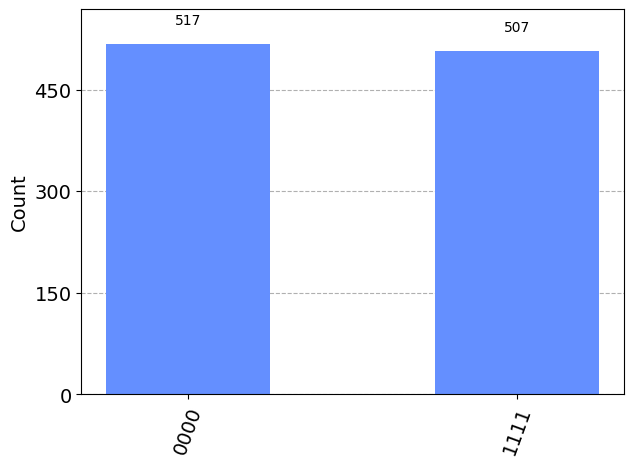

In [24]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

#### // Noise Example 1: Basic bit-flip error noise model

Error setup

In [25]:
# Probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([ ('X', p_reset), ('I', 1-p_reset) ])
error_meas  = pauli_error([ ('X', p_meas) , ('I', 1-p_meas)  ])
error_gate1 = pauli_error([ ('X', p_gate1), ('I', 1-p_gate1) ])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

Executing the noisy simulation

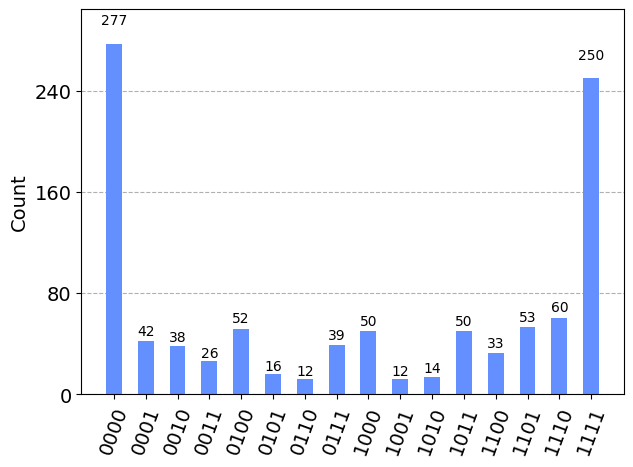

In [28]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

#### // Noise Example 2: T1/T2 thermal relaxation

In [30]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'u3', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


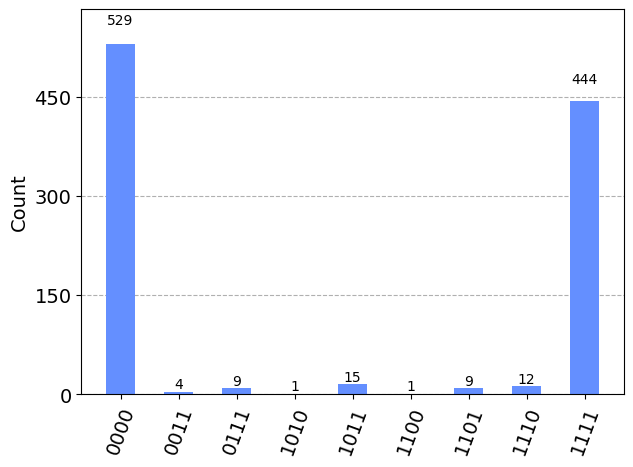

In [31]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)